In [1]:
%%bash
# Install or upgrade pip and the Python packages used in this notebook
pip install --upgrade pip
pip install numpy pandas scikit-learn seaborn matplotlib jupyterlab
# Optional packages that may be useful for later exercises
# pip install xgboost tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


## Dataset Context: X Education Lead Scoring

X Education is an online learning company that offers professional courses. Each day, many professionals visit their website to explore courses or fill out a form expressing interest. These individuals become **leads**.

The goal is to predict whether a lead will eventually **convert** into a paying customer (`converted` = 1) based on information about their background and interactions with the site.

## Columns in This Dataset

| Column | Description |
| :--------------------------- | :----------------------------------------------------------------------------------------------- |
| **lead_source** | Where the lead came from — for example, Google Ads, referrals, or social media. |
| **industry** | The professional industry or field the lead works in. |
| **number_of_courses_viewed** | How many courses the lead looked at on the platform. |
| **annual_income** | The lead’s reported annual income (may indicate purchasing power). |
| **employment_status** | Whether the lead is employed, self-employed, or a student. |
| **location** | Geographic location of the lead. |
| **interaction_count** | Number of interactions with the company (calls, emails, visits, etc.). |
| **lead_score** | A numerical score representing how promising the lead appears (higher = more likely to convert). |
| **converted** | Target variable: 1 if the lead enrolled in a course, 0 otherwise. |




## Data Preparation

Steps:

- Loaded dataset from the course URL into a DataFrame.
- Inspected schema and basic statistics (info/describe) to understand types and ranges.
- Handled missing values:
	- For categorical columns: filled NaNs with 'NA'.
	- For numerical columns: filled NaNs with 0.0.
- Normalized column names to snake_case (lowercase, spaces -> underscores).
- Standardized categorical text values (lowercase and strip spaces).
- Split data:
	- 20% held out as test set.
	- Remaining 80% split into 60% train and 20% validation.
- Reset indices after splitting.
- Separated target `converted` into `y_train`, `y_val`, `y_test`, and removed it from feature frames.
- Identified feature types: numerical (`num_cols`) and categorical (`cat_cols`).

This prepares clean, consistent inputs for vectorization and model training in the next steps.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)

df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


None

In [5]:
# Descriptive statistics
display(df.describe().round(2))

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
count,1462.00,1281.00,1462.00,1462.00,1462.00
mean,2.03,59886.27,2.98,0.51,0.62
std,1.45,15070.14,1.68,0.29,0.49
min,0.00,13929.00,0.00,0.00,0.00
25%,1.00,49698.00,2.00,0.26,0.00
50%,2.00,60148.00,3.00,0.51,1.00
75%,3.00,69639.00,4.00,0.75,1.00
max,9.00,109899.00,11.00,1.00,1.00


In [6]:
# Check for missing values
df.isnull().sum()

,0
lead_source,128
industry,134
number_of_courses_viewed,0
annual_income,181
employment_status,100
location,63
interaction_count,0
lead_score,0
converted,0


In [7]:
# categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

# fill missing values
df[cat_cols] = df[cat_cols].fillna('NA')

In [8]:
# numerical columns
num_cols = df.select_dtypes(include=['number']).columns

# fill missing values
df[num_cols] = df[num_cols].fillna(0.0)

In [9]:
# Normalize column names: lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [10]:
# normalize categorical text values (make lowercase, remove extra spaces)
for col in cat_cols:
    df[col] = df[col].str.lower().str.strip()

In [11]:
# first split off the test set (20%)
df_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

# then split the remaining 80% into 60% train and 20% val
df_train, df_val = train_test_split(df_full, test_size=0.25, random_state=1)

In [12]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [13]:
# Reset indices after splitting (convenience)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
# Extract the target
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

In [15]:
# Remove the target from the dataframes
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [16]:
# Numerical features
num_cols = df_train.select_dtypes(include=['number']).columns.tolist()
# Categorical features
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()

num_cols, cat_cols

(['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score'],
 ['lead_source', 'industry', 'employment_status', 'location'])

## ROC AUC numerical feature importance

ROC AUC could also be used to evaluate feature importance of **numerical variables**. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that

In [17]:
from sklearn.metrics import roc_auc_score

aucs = {}

for col in num_cols:
    scores = df_train[col].values
    auc = roc_auc_score(y_train, scores)

    # if correlation is negative
    if auc < 0.5:
        scores = -scores
        auc = roc_auc_score(y_train, scores)

    aucs[col] = float(auc)

aucs

{'number_of_courses_viewed': 0.7635680590007088,
 'annual_income': 0.5519578313253012,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176}

## Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression model with these parameters.

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
# build train/val dicts
dv = DictVectorizer(sparse=False)
train_dicts = (df_train[cat_cols + num_cols]).to_dict(orient='records')
val_dicts = (df_val[cat_cols + num_cols]).to_dict(orient='records')

In [20]:
# Fit the vectorizer on training data and transform to feature matries
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

NOTE: 

| Dataset           | Method            | Why                        |
| ----------------- | ----------------- | -------------------------- |
| Training          | `fit_transform()` | learn + apply mapping (to create numeric features)     |
| Validation / Test | `transform()`     | apply learned mapping only |


In [21]:
model = LogisticRegression(C=1.0, max_iter=1000)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

NOTE:

| Solver | Best for | Notes |
| :------------ | :------------------------------------ | :--------------------------- |
| `'liblinear'` | small datasets, binary classification | simple, stable |
| `'lbfgs'` (default) | larger datasets, multiclass | memory-efficient |
| `'saga'` | very large / sparse data | supports L1, elastic net |
| `'newton-cg'` | similar to lbfgs | slower convergence sometimes |


In [22]:
y_val_pred = model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
val_auc

np.float64(0.9218675103058191)

## Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [23]:
import numpy as np

thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_val_pred >= t).astype(int)
    predict_negative = (y_val_pred < t).astype(int)

    tp = (predict_positive & actual_positive).sum()
    # tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)

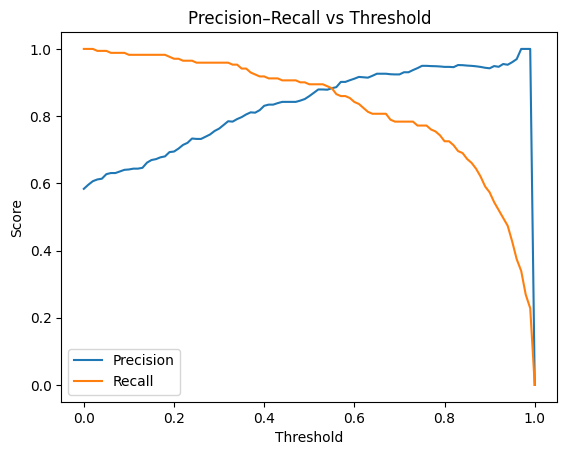

In [24]:
import matplotlib.pyplot as plt  

# plot
plt.figure()
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision–Recall vs Threshold')
plt.show()

## F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1: $$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$ Where $P$ is precision and $R$ is recall.

In [25]:
f1s = []

# compute F1 scores
for p, r in zip(precisions, recalls):
    if p + r == 0:
        f1s.append(0.0)
    else:
        f1s.append(2 * p * r / (p + r))

In [26]:
# find the best threshold
best_idx = int(np.argmax(f1s))
best_threshold = thresholds[best_idx]
best_f1 = f1s[best_idx]
best_threshold, best_f1

(np.float64(0.52), np.float64(0.8869565217391304))

## 5-Fold CV and Hyperparameter Tuning

Estimate **out-of-sample performance** and find the best **regularization strength (`C`)** for a Logistic Regression model using **5-fold cross-validation**.

* **Split strategy:** `KFold(n_splits=5, shuffle=True, random_state=1)` ensures reproducibility.

* **Per fold process:**

	1. **Vectorize features** using `DictVectorizer` (one-hot encoding for categoricals) fitted on the training portion.
	2. **Train** `LogisticRegression(solver='liblinear', C=..., max_iter=1000)`.
	3. **Predict** probabilities on the validation fold.
	4. **Compute** ROC AUC for that fold.

* **Hyperparameters tested:** `C ∈ [1e-6, 1e-3, 1]`

* **Aggregation:**
	* For each `C`, collect AUCs from all 5 folds.
	* Compute and store: `{C: (mean_auc, std_auc)}`.

In [27]:
# KFold is used to split a dataset into training and validation folds for cross-validation
from sklearn.model_selection import KFold

In [28]:
# Helper function to train the model on a given DataFrame and target array
def train(df_train, y_train, C=1.0):
    # Convert dataframe to list-of-dicts for DictVectorizer (handles categorical encoding)
    dicts = df_train[cat_cols + num_cols].to_dict(orient='records')

    # Fit a DictVectorizer to transform records into numeric feature matrix
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    # Create and fit logistic regression model; C controls regularization strength
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # Return fitted vectorizer and trained model for later use
    return dv, model

In [29]:
# Helper function to generate predicted probabilities for the positive class from a DataFrame
def predict(df, dv, model):
    # Convert dataframe to list-of-dicts and transform using existing vectorizer
    dicts = df[cat_cols + num_cols].to_dict(orient='records')

    X = dv.transform(dicts)
    # model.predict_proba returns two columns [P(class0), P(class1)] — take column 1 (positive class)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [30]:
# Install 'tqdm' to display progress bars during cross-validation
!pip install tqdm

In [31]:
# tqdm provides a nice progress bar for loops
from tqdm.auto import tqdm

In [32]:
# Perform K-Fold cross-validation for different regularization strengths C
n_splits = 5
results = {}

# Loop over candidate regularization strengths
for C in tqdm([0.000001, 0.001, 1]):
    # Create KFold splitter with shuffling for each hyperparameter run
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    fold_scores = []  # collect AUC scores for each fold

    for train_idx, val_idx in kfold.split(df_full):
        # Build train and validation DataFrames for this fold
        df_train_ = df_full.iloc[train_idx]
        df_val_ = df_full.iloc[val_idx]

        # Extract labels for this fold
        y_train = df_train_.converted.values
        y_val = df_val_.converted.values

        # Train a new model on the current fold's training data
        dv, model = train(df_train_, y_train, C=C)
        # Predict probabilities on the current fold's validation set
        y_pred = predict(df_val_, dv, model)

        # Compute AUC for this fold and append to scores
        auc = roc_auc_score(y_val, y_pred)
        fold_scores.append(auc)

        # After all folds, print mean and standard deviation of AUC for this hyperparameter
        mean_ = float(np.mean(fold_scores))
        std_  = float(np.std(fold_scores))
        results[C] = (round(mean_, 3), round(std_, 3))

results

  0%|          | 0/3 [00:00<?, ?it/s]

{1e-06: (0.822, 0.036), 0.001: (0.822, 0.036), 1: (0.822, 0.036)}

We select the C value with the **highest mean AUC**, which in this case is `C = 1`.
Note that the standard deviation (std) of AUC is about 0.036 for all tested values, indicating consistent performance across folds.